In [1]:
%matplotlib inline
import os, csv, time, datetime
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchinfo import summary 

# PREPROCESSING

In [2]:
def makeDataFrame(data_location, save_annot_to, output_csv):
    class_names = os.listdir(
        data_location)  # Получать название файлов, которые отдельно сохраняют классы
    class_names.sort()  # Сортируем чтобы совпало с тестовым датасетом
    with open(os.path.join(save_annot_to, output_csv), 'w', newline='') as tocsv:
        csvfile = csv.writer(tocsv, delimiter=',')
        csvfile.writerow(['file_name', 'file_path', 'class_name',
                        'class_index'])  # create column names
        for _class in class_names:
            # Путь к каждому классу
            class_folder = os.path.join(data_location, _class)
            
            # Список всех изображений
            class_img_list = os.listdir(class_folder)
            for imagejpg in class_img_list:
                
                # Путь к каждому изображению
                imagejpg_path = os.path.join(class_folder, imagejpg)
                
                # Записать в файле csv название изоб., путь к ему, его класс, и индекс класса
                csvfile.writerow(
                    [imagejpg, imagejpg_path, _class, class_names.index(_class)-1])
    return pd.read_csv(os.path.join(save_annot_to, output_csv))


# Посмотрите все классы с индексами
def check_dataframe(dataset_df):
    class_zip = zip(dataset_df['class_index'], dataset_df['class_name'])
    class_list = list(class_zip)
    return sorted(list(set(class_list)))

#  Преобразование изображений 
def transform_normalize():
    image_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    return image_transform

In [3]:
# for classn in class_names:
#     os.makedirs(os.path.join('../data/train',classn))

In [5]:
# CONSTANTS

# Location of the data
DATA_TRAIN_PATH = r'../data/train'
DATA_TEST_PATH = r'../data/test'
DF_PATH = r'../dataframes'

# INPUT OF OUR CONV NN
IMG_INPUT_WIDTH = 150
IMG_INPUT_HEIGHT = 150
IMG_INPUT_CHANNELS = 1

# MODEL CHARARCTERISTICS
BATCH_SIZE = 16
SAVE_MODEL_TO = r'../model'

In [6]:
# Make annotations for training and test data
train_df = makeDataFrame(DATA_TRAIN_PATH,DF_PATH,'train.csv')
test_df = makeDataFrame(DATA_TEST_PATH,DF_PATH,'test.csv')

In [7]:
train_df.sample(3)

,file_name,file_path,class_name,class_index
248,Video_Morris_Maze_Before_Irradiation_Day3_Prot...,../data/train/Random search/Video_Morris_Maze_...,Random search,5
352,Video_Morris_Maze_Before_Irradiation_Day1_Prot...,../data/train/Thigmotaxis/Video_Morris_Maze_Be...,Thigmotaxis,7
334,Video_Morris_Maze_90_days_Day1_Control_rat5_11...,../data/train/Scanning/Video_Morris_Maze_90_da...,Scanning,6


In [8]:
test_df.head()

,file_name,file_path,class_name,class_index
0,Video_Morris_Maze_30_days_Day2_Protons_rat1_11...,../data/test/Chaining/Video_Morris_Maze_30_day...,Chaining,0
1,Video_Morris_Maze_30_days_Day1_Protons_rat2_12...,../data/test/Chaining/Video_Morris_Maze_30_day...,Chaining,0
2,Video_Morris_Maze_30_days_Day1_Protons_rat7_12...,../data/test/Chaining/Video_Morris_Maze_30_day...,Chaining,0
3,Video_Morris_Maze_30_days_Day2_Control_rat5_11...,../data/test/Chaining/Video_Morris_Maze_30_day...,Chaining,0
4,Video_Morris_Maze_30_days_Day2_Protons_rat5_11...,../data/test/Chaining/Video_Morris_Maze_30_day...,Chaining,0


In [9]:
# Delete rows with '.ipynb_checkpoints'
train_df = train_df[~(train_df['file_name']=='.ipynb_checkpoints')]
test_df = test_df[~(test_df['file_name']=='.ipynb_checkpoints')]

In [10]:
# Check the correctness of classes and indexes
class_names = list(train_df['class_name'].unique())
print(f'Class names: {class_names}')
print(check_dataframe(train_df))
print(check_dataframe(test_df))

Class names: ['Chaining', 'Direct path', 'Direct search', 'Focal search', 'Indirect search', 'Random search', 'Scanning', 'Thigmotaxis']
[(0, 'Chaining'), (1, 'Direct path'), (2, 'Direct search'), (3, 'Focal search'), (4, 'Indirect search'), (5, 'Random search'), (6, 'Scanning'), (7, 'Thigmotaxis')]
[(0, 'Chaining'), (1, 'Direct path'), (2, 'Direct search'), (3, 'Focal search'), (4, 'Indirect search'), (5, 'Random search'), (6, 'Scanning'), (7, 'Thigmotaxis')]


In [11]:
# How big are our the datasets?
for dataname, dataset in zip(["Train dataset","\nTest dataset"],[train_df, test_df]):
    print(dataname)
    for i in range(len(class_names)):
        num = sum(dataset['class_index'] == i)
        print(f'{class_names[i].capitalize()}:\t\t{num} images')

Train dataset
Chaining:		32 images
Direct path:		54 images
Direct search:		24 images
Focal search:		37 images
Indirect search:		47 images
Random search:		90 images
Scanning:		53 images
Thigmotaxis:		13 images

Test dataset
Chaining:		8 images
Direct path:		13 images
Direct search:		6 images
Focal search:		9 images
Indirect search:		12 images
Random search:		22 images
Scanning:		13 images
Thigmotaxis:		5 images


# DATASET CLASS

In [12]:
class thigmotaxisDataset(torch.utils.data.Dataset):
    def __init__(self, data_df,IMG_SIZE = (IMG_INPUT_WIDTH,IMG_INPUT_HEIGHT), transform=None):
        self.data_df = data_df
        # root directory of images, leave "" if using the image path column in the __getitem__ method
        self.root_directory = ""
        self.transform = transform
        self.dim = IMG_SIZE

    def __len__(self):
        # return length (numer of rows) of the dataframe
        return len(self.data_df)

    def __getitem__(self, idx):
        
        # use class name column (index = 2) in csv file
        class_name = self.data_df.iloc[idx, 2]
        # use class index column (index = 3) in csv file
        class_index = self.data_df.iloc[idx, 3]
        
        # use image path column (index = 1) in csv file
        image_path = self.data_df.iloc[idx, 1]
        image = cv2.imread(image_path)  # read image by cv2
        
        if image is None:
            image,class_name,class_index = self.__getitem__(idx-1)
        
        # convert from BGR to GRAY
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Resize the image to IMG_SIZE
        image = cv2.resize(image,dsize=self.dim, interpolation=cv2.INTER_AREA)
        
        # # DIlATE THE IMAGE FOR BETTER RESULTS
        # kernel = np.ones((3, 3), 'uint8')
        # image = cv2.dilate(image, kernel, iterations=1)
        
        # BINARIZE THE IMAGE
        ret,image = cv2.threshold(image,1,255,cv2.THRESH_BINARY)
        
        if self.transform:
            image = self.transform(image)
        # when accessing an instance via index, 3 outputs are returned - the image, class name and class index
        return image, class_name, class_index

    def visualize(self, n_sample=10, figsize=(12,6)):
        plt.figure(figsize=figsize)
        nrows = int(np.ceil(n_sample/5)) # figure = nrows * 5columns plots 
        for i in range(n_sample):
            idx = np.random.randint(0, len(self.data_df))
            image, class_name, class_index = self.__getitem__(idx)
            ax = plt.subplot(nrows, 5, i+1)  # create an axis
            # create a name of the axis based on the img name
            ax.title.set_text(f'{class_name}-{str(class_index)}')
            ax.set_xticks([])
            ax.set_yticks([])
            if self.transform == None:
                plt.imshow(image)
            else:
                plt.imshow((0.5+0.5*image).permute(1, 2, 0),cmap='gray')
        plt.tight_layout()

In [13]:
# TRANSFORM DATA
image_transform = transform_normalize()

trainDataset = thigmotaxisDataset(train_df, transform=image_transform)
testDataset = thigmotaxisDataset(test_df, transform=image_transform)

In [ ]:
# image = cv2.imread(train_df['file_path'][32])
# # convert from BGR to GRAY
# image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# # Resize the image to IMG_SIZE
# image = cv2.resize(image,dsize=(150,150), interpolation=cv2.INTER_AREA)

# # BINARIZE THE IMAGE
# ret,image = cv2.threshold(image,1,255,cv2.THRESH_BINARY)
# # # DIlATE THE IMAGE FOR BETTER RESULTS
# # kernel = np.ones((3, 3), 'uint8')
# # image = cv2.dilate(image, kernel, iterations=1)

# cv2.imwrite('savedImage.jpg',image)
# plt.figure(figsize=(6,6))
# plt.imshow(image,cmap='gray')

# plt.show()

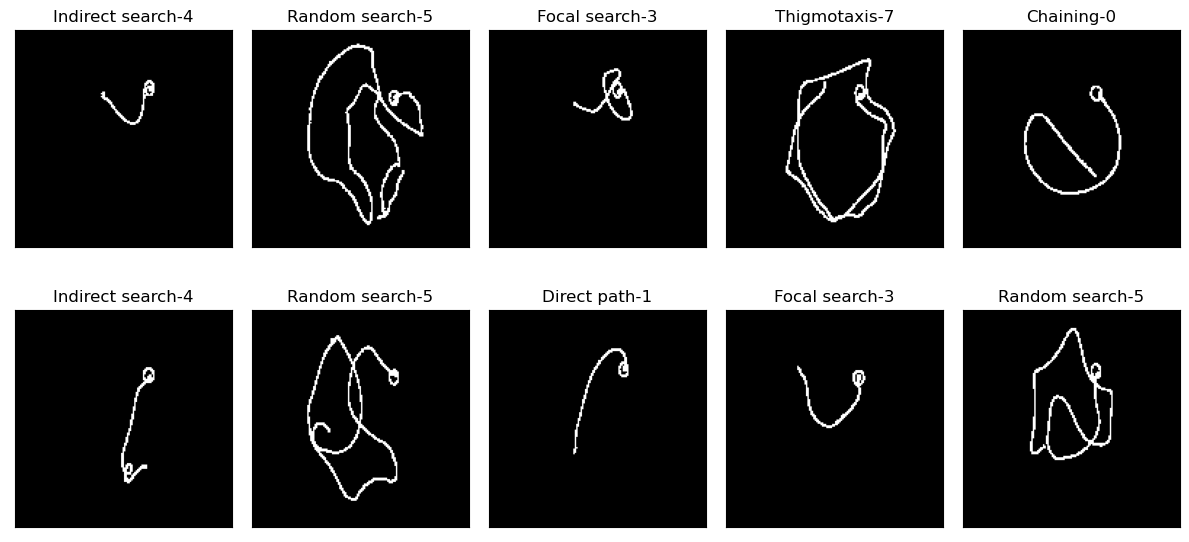

In [14]:
trainDataset.visualize()

# DATALOADER

In [136]:
# Number of cpus (for parallel programming)
# !lscpu

In [15]:
trainloader = DataLoader(trainDataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=10)
testloader = DataLoader(testDataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=10)

In [16]:
## import torch.nn.functional as F
import torch.nn.functional as F

class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=20,kernel_size=9)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=11,stride=1)
        self.conv2 = torch.nn.Conv2d(in_channels=20, out_channels=50,kernel_size=5)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=8,stride=5)
        
        self.fc1 = torch.nn.Linear(50*25*25, 500)
        self.fc2 = torch.nn.Linear(500, 8)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        x = F.relu(F.dropout(x, 0.25))
        x = self.fc2(x)
        return x

# Check image size in layers of the network

In [91]:
conv1 = torch.nn.Conv2d(in_channels=1, out_channels=20,kernel_size=9)
pool1 = torch.nn.MaxPool2d(kernel_size=11,stride=1)
conv2 = torch.nn.Conv2d(in_channels=20, out_channels=50,kernel_size=5)
pool2 = torch.nn.MaxPool2d(kernel_size=8,stride=5)

In [92]:
inputx.shape

torch.Size([1, 150, 150])

In [93]:
output = pool1(F.relu(conv1(inputx)))
output.shape

torch.Size([20, 132, 132])

In [94]:
output = pool2(F.relu(conv2(output)))
output.shape

torch.Size([50, 25, 25])

# Training section

In [17]:
def default_loss():
    return torch.nn.CrossEntropyLoss()

def default_optimizer(model, learning_rate = 0.001):
    return optim.SGD(model.parameters(), lr = learning_rate,momentum=0.9)

def get_default_device():
    """Picking GPU if available or else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [18]:
def train_model(model, device, trainloader, testloader, criterion, optimizer, num_epochs=5):
    # device = get_default_device()
    model = model.to(device)
    train_result_dict = {'epoch': [], 'train_loss': [],'test_loss': [],
                         'train_accuracy': [],'test_accuracy': [], 'time': []}

    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        model.train()  # set the model to training mode, parameters are updated
        for i, data in enumerate(trainloader, 0):
            image, class_name, class_index = data
            image = image.to(device)
            class_index = class_index.to(device)
            optimizer.zero_grad()  # zero the parameter gradients
            outputs = model(image)  # forward propagation
            loss = criterion(outputs, class_index)  # loss calculation
            train_loss += loss.item()
            loss.backward()  # backward propagation
            optimizer.step()  # params update
                  
            _, predicted = torch.max(outputs.data, 1)
            train_total += class_index.size(0)
            train_correct += (predicted == class_index).sum().item()
            
        # Here Test(validation) 
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        model.eval()  # set the model to evaluation mode, parameters are frozen
        for i, data in enumerate(testloader, 0):
            image, class_name, class_index = data
            image = image.to(device)
            class_index = class_index.to(device)
            outputs = model(image)
            loss = criterion(outputs, class_index)
            test_loss += loss.item()
            
            
            _, predicted = torch.max(outputs.data, 1)
            test_total += class_index.size(0)
            test_correct += (predicted == class_index).sum().item()

        # print statistics every 1 epoch
        # divide by the length of the minibatch because loss.item() returns the loss of the whole minibatch
        train_loss_result = round(train_loss / len(trainloader), 3)
        test_loss_result = round(test_loss / len(testloader), 3)
        train_accuracy = round(float(train_correct)/float(train_total)*100, 2)
        test_accuracy = round(float(test_correct)/float(test_total)*100, 2)

        epoch_time = round(time.time() - start_time, 1)
        # add statistics to the dictionary:
        train_result_dict['epoch'].append(epoch + 1)
        train_result_dict['train_loss'].append(train_loss_result)
        train_result_dict['test_loss'].append(test_loss_result)
        train_result_dict['train_accuracy'].append(train_accuracy)
        train_result_dict['test_accuracy'].append(test_accuracy)
        train_result_dict['time'].append(epoch_time)

        print(f' Epoch {epoch+1} \t Training Loss: {train_loss_result} \t Test Loss: {test_loss_result}') 
        print(f' Epoch Train Accuracy (%): {train_accuracy} \t Epoch test Accuracy (%) {test_accuracy}')
        print(f' Epoch Time (s): {epoch_time}')
    # return the trained model and the loss dictionary
    return model, train_result_dict

In [19]:
# Initialize key variables
model = Net()
criterion = default_loss()
optimizer = default_optimizer(model)
device = get_default_device()
num_epochs = 10

In [20]:
def summary_model(model, device):
    """ Move model to GPU and print model summary
    """
    # Define the model and move it to GPU:
    model = model
    model = model.to(device)
    print(f'Current device: {str(device)}')
    print(f'Is Model on CUDA: {str(next(model.parameters()).is_cuda)}')
    
    # Display model summary:
    return summary(model, input_size=(BATCH_SIZE,IMG_INPUT_CHANNELS, IMG_INPUT_WIDTH, IMG_INPUT_HEIGHT))

In [21]:
# Model summary
summary_model(model, device)

Current device: cpu
Is Model on CUDA: False


Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [16, 8]                   --
├─Conv2d: 1-1                            [16, 20, 142, 142]        1,640
├─MaxPool2d: 1-2                         [16, 20, 132, 132]        --
├─Conv2d: 1-3                            [16, 50, 128, 128]        25,050
├─MaxPool2d: 1-4                         [16, 50, 25, 25]          --
├─Linear: 1-5                            [16, 500]                 15,625,500
├─Linear: 1-6                            [16, 8]                   4,008
Total params: 15,656,198
Trainable params: 15,656,198
Non-trainable params: 0
Total mult-adds (G): 7.35
Input size (MB): 1.44
Forward/backward pass size (MB): 156.54
Params size (MB): 62.62
Estimated Total Size (MB): 220.61

In [24]:
# Train the model
MODEL_10_EPOCHS, RESULTS_10_EPOCHS =  train_model(model, device, trainloader, testloader,
                                           criterion, optimizer, num_epochs=10)

 Epoch 1 	 Training Loss: 0.564 	 Test Loss: 0.87
 Epoch Train Accuracy (%): 78.86 	 Epoch test Accuracy (%) 70.45
 Epoch Time (s): 44.0
 Epoch 2 	 Training Loss: 0.47 	 Test Loss: 1.001
 Epoch Train Accuracy (%): 82.29 	 Epoch test Accuracy (%) 69.32
 Epoch Time (s): 43.6
 Epoch 3 	 Training Loss: 0.48 	 Test Loss: 1.142
 Epoch Train Accuracy (%): 82.57 	 Epoch test Accuracy (%) 65.91
 Epoch Time (s): 43.2
 Epoch 4 	 Training Loss: 0.506 	 Test Loss: 0.885
 Epoch Train Accuracy (%): 80.57 	 Epoch test Accuracy (%) 73.86
 Epoch Time (s): 43.9
 Epoch 5 	 Training Loss: 0.609 	 Test Loss: 1.233
 Epoch Train Accuracy (%): 79.71 	 Epoch test Accuracy (%) 63.64
 Epoch Time (s): 42.5
 Epoch 6 	 Training Loss: 0.401 	 Test Loss: 0.965
 Epoch Train Accuracy (%): 85.43 	 Epoch test Accuracy (%) 70.45
 Epoch Time (s): 42.6
 Epoch 7 	 Training Loss: 0.353 	 Test Loss: 1.114
 Epoch Train Accuracy (%): 88.57 	 Epoch test Accuracy (%) 70.45
 Epoch Time (s): 44.7
 Epoch 8 	 Training Loss: 0.461 	 Tes

# USEFUL FUNCTIONS

In [22]:
def prediction(model, device, data_loader):
    '''
    Calculate predicted class indices of the data_loader by the trained model 
    '''
    model = model.to(device)
    y_pred = []
    y_true = []
    with torch.no_grad():
        for data in data_loader:
            image, class_name, class_index = data
            image = image.to(device)
            class_index = class_index.to(device)
            outputs = model(image)
            outputs = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
            y_pred.extend(outputs)
            class_index = class_index.data.cpu().numpy()
            y_true.extend(class_index)
    return y_pred, y_true

In [23]:
def model_performance(y_true, y_pred, class_names):
    num_classes = len(class_names)
    
    # build confusion matrix based on predictions and class_index
    confusion_matrix = torch.zeros(num_classes, num_classes)
    for i in range(len(y_pred)):
        # true label on row, predicted on column
        confusion_matrix[y_true[i], y_pred[i]] += 1

    # PER-CLASS METRICS:
    # calculate accuracy, precision, recall, f1 for each class:
    accuracy = torch.zeros(num_classes)
    precision = torch.zeros(num_classes)
    recall = torch.zeros(num_classes)
    f1_score = torch.zeros(num_classes)
    for i in range(num_classes):
        # find TP, FP, FN, TN for each class:
        TP = confusion_matrix[i, i]
        FP = torch.sum(confusion_matrix[i, :]) - TP
        FN = torch.sum(confusion_matrix[:, i]) - TP
        TN = torch.sum(confusion_matrix) - TP - FP - FN
        # calculate accuracy, precision, recall, f1 for each class:
        accuracy[i] = (TP+TN)/(TP+FP+FN+TN)
        precision[i] = TP/(TP+FP)
        recall[i] = TP/(TP+FN)
        f1_score[i] = 2*precision[i]*recall[i]/(precision[i]+recall[i])
    # calculate support for each class
    support = torch.sum(confusion_matrix, dim=0)
    # calculate support proportion for each class
    support_prop = support/torch.sum(support)

    # OVERALL METRICS
    # calculate overall accuracy:
    overall_acc = torch.sum(torch.diag(confusion_matrix)
                            )/torch.sum(confusion_matrix)
    # calculate macro average F1 score:
    macro_avg_f1_score = torch.sum(f1_score)/num_classes
    # calculate weighted average rF1 score based on support proportion:
    weighted_avg_f1_score = torch.sum(f1_score*support_prop)

    TP = torch.diag(confusion_matrix)
    FP = torch.sum(confusion_matrix, dim=1) - TP
    FN = torch.sum(confusion_matrix, dim=0) - TP
    TN = torch.sum(confusion_matrix) - (TP + FP + FN)

    # calculate micro average f1 score based on TP, FP, FN
    micro_avg_f1_score = torch.sum(
        2*TP)/(torch.sum(2*TP)+torch.sum(FP)+torch.sum(FN))

    # METRICS PRESENTATION
    # performance for each class
    class_columns = ['accuracy', 'precision', 'recall', 'f1_score']
    class_data_raw = [accuracy.numpy(), precision.numpy(),
                      recall.numpy(), f1_score.numpy()]
    class_data = np.around(class_data_raw, decimals=3)
    df_class_raw = pd.DataFrame(
        class_data, index=class_columns, columns=class_names)
    class_metrics = df_class_raw.T

    # overall performance
    overall_columns = ['accuracy', 'f1_mirco', 'f1_macro', 'f1_weighted']
    overall_data_raw = [overall_acc.numpy(), micro_avg_f1_score.numpy(
    ), macro_avg_f1_score.numpy(), weighted_avg_f1_score.numpy()]
    overall_data = np.around(overall_data_raw, decimals=3)
    overall_metrics = pd.DataFrame(
        overall_data, index=overall_columns, columns=['overall'])
    return confusion_matrix, class_metrics, overall_metrics

def get_current_timestamp():
    now = datetime.datetime.now()
    return now.strftime("%Y%m%d_%H%M%S")


def save_model_with_timestamp(model, filepath = SAVE_MODEL_TO):
    filename = f'{get_current_timestamp()}_cnn_model.pt'
    filepath = os.path.join(filepath, filename)
    torch.save(model.state_dict(), filepath)
    return print('Saved model to: ', filepath)


def save_csv_with_timestamp(train_result_dict, filepath = SAVE_MODEL_TO):
    filename = f'{get_current_timestamp()}_training_report.csv'
    filepath = os.path.join(filepath, filename)
    df = pd.DataFrame(train_result_dict)
    df.to_csv(filepath)
    return print('Saved training report to: ', filepath)

In [24]:
def plot_results(train_result:dict,trained_model_num_epochs,figsize=(15, 7)):
    # Define Datatrain_result
    df = pd.DataFrame(train_result)
    x = df['epoch']
    data_1 = df['train_loss']
    data_2 = df['test_loss']
    data_3 = df['train_accuracy']
    data_4 = df['test_accuracy']

    # Create Plot
    plt.figure(figsize=figsize)
    ax1 = plt.subplot(1,2,1)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss function')
    ax1.plot(x, data_1, color='red', label='training loss')
    ax1.plot(x, data_2, color='blue', label='Test loss')
    ax1.legend(loc='best')

    # Adding Twin Axes
    ax2 = plt.subplot(1,2,2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuraccy')
    ax2.set_title('Model quality')
    ax2.set_ylim([1,100])
    ax2.plot(x, data_3, color='red', label='Training Accuracy')
    ax2.plot(x, data_4, color='blue', label='Test Accuracy')
    ax2.legend(loc='best')
    
    plt.savefig(f'MODEL_{trained_model_num_epochs}_EPOCHS_{get_current_timestamp()}.jpg',dpi=300)
    # Show plot
    plt.show()

In [48]:
save_model_with_timestamp(trained_model, SAVE_MODEL_TO)

Saved model to:  ../model/20230417_141846_cnn_model.pt


In [25]:
# trained_model_list = os.listdir(SAVE_MODEL_TO)
# MODEL_10_EPOCH_PATH = os.path.join(SAVE_MODEL_TO, trained_model_list[0])

# LOADED_MODEL_10_EPOCHS = Net()
# device = get_default_device()

# print(LOADED_MODEL_10_EPOCHS)
# LOADED_MODEL_10_EPOCHS.load_state_dict(torch.load(MODEL_10_EPOCH_PATH))
trained_model = Net()
device = get_default_device()

print(trained_model)
trained_model.load_state_dict(torch.load(r'trained_net.pth'))

Net(
  (conv1): Conv2d(1, 20, kernel_size=(9, 9), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=11, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=8, stride=5, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=31250, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=8, bias=True)
)


<All keys matched successfully>

In [27]:
# check accuracy on test set
y_pred, y_true = prediction(model = trained_model,
                            device = device, data_loader = testloader)
confusion_matrix, class_metrics, overall_metrics = model_performance(y_pred, y_true, 
                                                                     class_names = class_names)
print(confusion_matrix)
print(class_metrics)
print(overall_metrics)

tensor([[ 0.,  0.,  0.,  0.,  0.,  2.,  1.,  3.],
        [ 1., 13.,  4.,  3.,  4.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  3.,  0.,  0.,  1.,  0.],
        [ 6.,  0.,  2.,  2.,  8.,  2.,  5.,  0.],
        [ 1.,  0.,  0.,  0.,  0., 13.,  0.,  2.],
        [ 0.,  0.,  0.,  0.,  0.,  5.,  5.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
                 accuracy  precision  recall  f1_score
Chaining            0.841      0.000   0.000       NaN
Direct path         0.852      0.500   1.000     0.667
Direct search       0.920      0.000   0.000       NaN
Focal search        0.920      0.750   0.333     0.462
Indirect search     0.761      0.320   0.667     0.432
Random search       0.864      0.812   0.591     0.684
Scanning            0.852      0.500   0.385     0.435
Thigmotaxis         0.943        NaN   0.000       NaN
             overall
accuracy       0.477
f1_mirco       0.477
f1_macro         NaN
f1_weighted      NaN

In [62]:
for i in range(8):
    num = sum(np.array(y_true)==i)
    print(f'Class{i+1}: {num}')

Class1: 8
Class2: 13
Class3: 6
Class4: 9
Class5: 12
Class6: 22
Class7: 13
Class8: 5


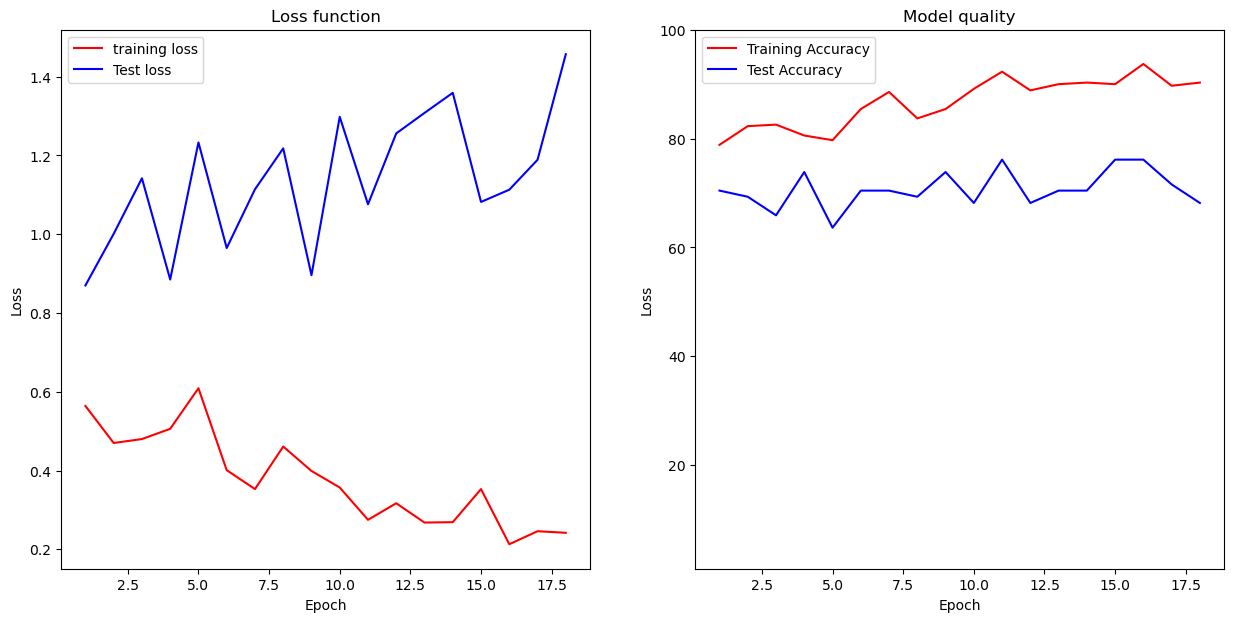

In [35]:
plot_results(results_dict)

In [ ]:
MODEL_15_EPOCHS, RESULTS_15_EPOCHS =  train_model(model, device, trainloader, testloader,
                                           criterion, optimizer, num_epochs=10)

In [ ]:
MODEL_20_EPOCHS, RESULTS_20_EPOCHS =  train_model(model, device, trainloader, testloader,
                                           criterion, optimizer, num_epochs=10)